## Recommendation Systems using surprise (Collaborative filtering)

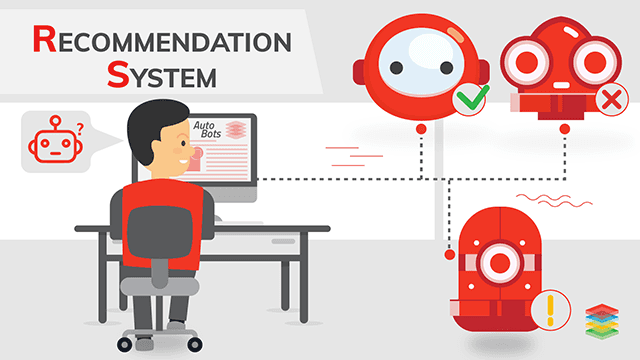

## Import Libraries

In [2]:
!pip install surprise

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts_sklearn
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split as tts_surprise
%matplotlib inline

## Read and explore the given dataset

In [4]:
url="http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Electronics.csv"

In [5]:
df = pd.read_csv(url,
                 header=None,
                 names=["userId","productId","Rating","timestamp"])

In [6]:
df.shape

(7824482, 4)

In [7]:
df=df.sample(124482)

In [8]:
df.head()

,userId,productId,Rating,timestamp
6218552,A21OJ2XPSKHYBA,B008GEC6DQ,5.0,1379030400
7017308,A2HXMO2BFKXIAJ,B00B46XUQU,5.0,1348531200
5202672,AXD0DX02HU527,B005UL97HQ,1.0,1381190400
2331985,A3TLP23NUR56VJ,B001U02JZ8,5.0,1264550400
3796080,A2THG10JF1R9ZW,B0041XQBU0,5.0,1316736000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124482 entries, 6218552 to 3881967
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     124482 non-null  object 
 1   productId  124482 non-null  object 
 2   Rating     124482 non-null  float64
 3   timestamp  124482 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.7+ MB


### Percentage of missing values

In [10]:
df.isna().sum()/len(df.index) * 100

userId       0.0
productId    0.0
Rating       0.0
timestamp    0.0
dtype: float64

In [11]:
len(df["userId"].unique())

120195

In [12]:
len(df["productId"].unique())

55314

In [13]:
df["Rating"].unique()

array([5., 1., 3., 4., 2.])

In [14]:
df["Rating"] = df["Rating"].astype("int")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124482 entries, 6218552 to 3881967
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     124482 non-null  object
 1   productId  124482 non-null  object
 2   Rating     124482 non-null  int64 
 3   timestamp  124482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.7+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


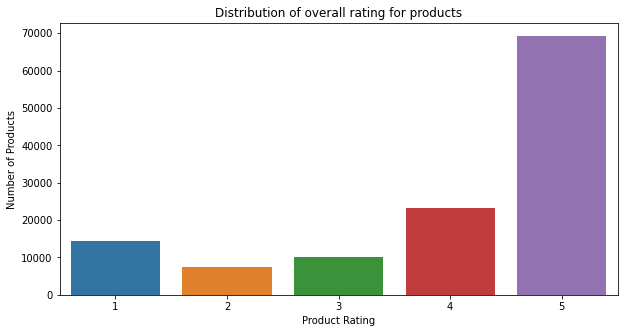

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(df["Rating"])
plt.xlabel("Product Rating")
plt.ylabel("Number of Products")
plt.title("Distribution of overall rating for products")
plt.show()

In [17]:
df["productId"].value_counts()

B0074BW614    280
B00DR0PDNE    272
B007WTAJTO    249
B0019EHU8G    221
B003ES5ZUU    184
             ... 
B00EB7812C      1
B003LNYEVY      1
B00E9I2Y7G      1
B0002SAF64      1
B00FAREI1A      1
Name: productId, Length: 55314, dtype: int64

## subset

reduce the data by only considering the products which have at least 10 ratings

In [18]:
prodRatings = df["productId"].value_counts()

In [19]:
# Products which have at least 100 ratings
prodsAbove100Ratings = prodRatings[prodRatings >= 100].index.values

In [20]:
# Filter dataframe to keep only above products
df = df[df["productId"].isin(prodsAbove100Ratings)]

In [21]:
df.shape

(3167, 4)

## Split the dataset

In [22]:
train, test = tts_sklearn(df,test_size=0.3,random_state=42)

In [23]:
train.shape

(2216, 4)

In [24]:
test.shape

(951, 4)

### Popularity Based Recommendations

In [25]:
train.groupby("productId")["Rating"].mean().sort_values(ascending=False).head()

productId
B003ES5ZUU    4.745763
B000LRMS66    4.729167
B007R5YDYA    4.682243
B0019EHU8G    4.661972
B003ELYQGG    4.552846
Name: Rating, dtype: float64

In [26]:
def topK_popularity(K=10):
    topK = train.groupby("productId")["Rating"].mean().sort_values(ascending=False).head(K)
    print("===================================================")
    print("==================TOP {}============================".format(K))
    for i in range(K):
        product = topK.index[i]
        prodRating = topK.iloc[i]
        print("{}.\tProduct: {}\tMean Rating: {}".format(i+1,product,prodRating))
    print("===================================================")
    print("===================================================")
    return topK

In [27]:
# Top-10 recommendations
top5_popularity = topK_popularity(10)

==================TOP 10============================
1.	Product: B003ES5ZUU	Mean Rating: 4.745762711864407
2.	Product: B000LRMS66	Mean Rating: 4.729166666666667
3.	Product: B007R5YDYA	Mean Rating: 4.682242990654205
4.	Product: B0019EHU8G	Mean Rating: 4.661971830985915
5.	Product: B003ELYQGG	Mean Rating: 4.5528455284552845
6.	Product: B0074BW614	Mean Rating: 4.5
7.	Product: B003LR7ME6	Mean Rating: 4.493670886075949
8.	Product: B00622AG6S	Mean Rating: 4.486486486486487
9.	Product: B0002L5R78	Mean Rating: 4.436507936507937
10.	Product: B007WTAJTO	Mean Rating: 4.377049180327869


## Collaborative Filtering Model

In [28]:
reader = Reader(rating_scale=(1,5))
# Surprise dataset
df_sur = Dataset.load_from_df(df[['userId','productId','Rating']],reader)

In [29]:
train_sur, test_sur = tts_surprise(df_sur, test_size=0.30, random_state=42)

### Item-Item based collaborative filtering model

In [30]:
item_item = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [31]:
item_item.fit(train_sur)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### User-User based collaborative filtering model

In [32]:
user_user = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})

In [33]:
user_user.fit(train_sur)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### Evaluate the models

In [34]:
#  predictions for item-item collaborative model
test_item_item = item_item.test(test_sur)

In [35]:
# predictions for user-user collaborative model
test_user_user = user_user.test(test_sur)

In [36]:
#  RMSE
print("User-user Collaborative Filtering Model : Test Set")
accuracy.rmse(test_item_item, verbose=True)


User-user Collaborative Filtering Model : Test Set
RMSE: 1.1356


1.1356204173365894

In [37]:
print("Item-item Collaborative Filtering Model : Test Set")
accuracy.rmse(test_user_user, verbose=True);

Item-item Collaborative Filtering Model : Test Set
RMSE: 1.1353


In [38]:
# Sorted popularity based movies
sorted_pop = train.groupby("productId")["Rating"].mean().sort_values(ascending=False)

In [39]:
def expectedRating(movie):
    try:
        return sorted_pop[movie]
    except:
        return 0

In [40]:
# Add a new column with expected rating
test["Expected"] = test["productId"].apply(expectedRating)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
test.head()

,userId,productId,Rating,timestamp,Expected
6315990,A3R5X5HOTP1M3G,B008OHNZI0,5,1381968000,4.370000
5601599,A2Z8I73PYPMQ6B,B0074BW614,5,1353283200,4.500000
3320031,A1VIE45I45QGW4,B003ES5ZUU,5,1399075200,4.745763
3314889,A2O56OMYFOKV47,B003ES5ZUU,4,1360886400,4.745763
5389659,A37ZXRPQEVI9N9,B006GWO5WK,4,1378425600,4.259843


In [42]:
# Calculate RMSE of ratings
test["error"] = (test["Rating"] - test["Expected"])**2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
test.head()

,userId,productId,Rating,timestamp,Expected,error
6315990,A3R5X5HOTP1M3G,B008OHNZI0,5,1381968000,4.370000,0.396900
5601599,A2Z8I73PYPMQ6B,B0074BW614,5,1353283200,4.500000,0.250000
3320031,A1VIE45I45QGW4,B003ES5ZUU,5,1399075200,4.745763,0.064637
3314889,A2O56OMYFOKV47,B003ES5ZUU,4,1360886400,4.745763,0.556162
5389659,A37ZXRPQEVI9N9,B006GWO5WK,4,1378425600,4.259843,0.067518


In [44]:
print("Total RMSE: {:.4f}".format(np.sqrt(test["error"].sum()/len(test.index))))

Total RMSE: 1.1222
